# 2.3 - Macrobond web API - Screening with a Keyword

*Performing coverage checks based on a keyword*

This notebook aims to provide examples of how to use Macrobond's web API call methods as well as insights on the key attributes used to display the output in an understandable format.

We will focus here on using the Search method based on a **keyword** filter. This helps you build a list of time series potentially relating to a common theme.

*Full error handling is omitted for brevity*

***

## Importing packages

In [2]:
import pandas
from matplotlib import pyplot

from macrobond_financial.common import Credentials
from macrobond_financial.web import WebClient

***

## Authentication

If you have a Macrobond's web API account, enter your *client_id* and *client_secret* below.

In [3]:
credentials = Credentials()

***

## Get the data - Keyword: Government Securities Auctions

Note that we are using here the Search endpoint with filters on keyword `text=Government Securities Auctions` and `Frequency=daily` time series in this example.

Feel free to refer to https://api.macrobondfinancial.com/swagger/index.html to get the comprehensive list of web API endpoints and parameters used.

***

## Visualising the data
Let's evaluate Macrobond's coverage for daily time series related to government securities auctions.

In [4]:
with WebClient(credentials.client_id, credentials.client_secret) as api:
    data_frame = api.entity_search(
        text="Government Securities Auctions",
        entity_types="TimeSeries",
        must_have_values={"Frequency": "daily"},
        include_discontinued=False,
    ).data_frame(
        columns=[
            "Name",
            "FullDescription",
            "Description",
            "Region",
            "Category",
            "Frequency",
            "Source",
            "Class",
            "PriceType",
        ]
    )
data_frame.head(10)

,Name,FullDescription,Description,Region,Category,Frequency,Source,Class,PriceType
0,usrate0691,"United States, Government Securities Auctions,...",NaN,[us],rate,daily,src_ustreas,stock,[myield]
1,usrate0690,"United States, Government Securities Auctions,...",NaN,[us],rate,daily,src_ustreas,stock,[yield]
2,usrate0689,"United States, Government Securities Auctions,...",NaN,[us],rate,daily,src_ustreas,stock,[yield]
3,usrate0687,"United States, Government Securities Auctions,...",NaN,[us],rate,daily,src_ustreas,stock,[bidcover]
4,usrate0685,"United States, Government Securities Auctions,...",Total Tendered,[us],rate,daily,src_ustreas,flow,NaN
5,usrate0686,"United States, Government Securities Auctions,...",Total Accepted,[us],rate,daily,src_ustreas,flow,NaN
6,usrate0694,"United States, Government Securities Auctions,...",Treasury Direct Accepted,[us],rate,daily,src_ustreas,flow,NaN
7,usrate0981,"United States, Government Securities Auctions,...","Allotment, Dealers & Brokers",[us],rate,daily,src_ustreas,flow,NaN
8,usrate0683,"United States, Government Securities Auctions,...","Competitive, Accepted",[us],rate,daily,src_ustreas,flow,NaN
9,usrate0681,"United States, Government Securities Auctions,...","Indirect Bidder, Accepted",[us],rate,daily,src_ustreas,flow,NaN


### Let's make sense of the attribute PriceType

We will use here the metadata endpoint from the web API as detailed in the notebook **1.1 - Macrobond web API - Metadata Navigation**

In [5]:
with WebClient(credentials.client_id, credentials.client_secret) as api:
    data_frame = api.metadata_get_attribute_information("PriceType").data_frame()
data_frame

,name,description,comment,value_type,uses_value_list,can_list_values,can_have_multiple_values,is_database_entity
0,PriceType,Price type,Provides additional information for price rela...,8,True,True,True,False


As the PriceType uses values from list and is not a free text attribute, let's have a look at its values to be used later as a group.

In [6]:
with WebClient(credentials.client_id, credentials.client_secret) as api:
    df3 = api.metadata_list_values("PriceType").data_frame(
        columns=["value", "description", "comment"]
    )
df3

,value,description,comment
0,myield,Median Yield,None
1,yield,Yield,None
2,bidcover,Bid to Cover Ratio,None
3,intrate,Average Interest Rate,None
4,ayield,Average Yield,None
...,...,...,...
655,opstock,Opening Stock,None
656,injeb,Injectability,None
657,delivcap,Deliverability,None
658,inflow,Inflow,None


Now that we get a sense of potential groupings we can achieve thanks to the metadata, let's manipulate the ones that will be used.

In [7]:
with WebClient(credentials.client_id, credentials.client_secret) as api:
    data_frame = api.entity_search(
        text="Government Securities Auctions",
        entity_types="TimeSeries",
        must_have_values={"Frequency": "daily"},
        include_discontinued=False,
    ).data_frame(
        columns=[
            "Name",
            "FullDescription",
            "Description",
            "Region",
            "Category",
            "Frequency",
            "Source",
            "Class",
            "PriceType",
        ]
    )

data_frame["RegionString"] = data_frame["Region"].apply(
    lambda x: "" if pandas.isna(x) else ", ".join(map(str, x))
)

# Need to account for NaN values before converting to a string
data_frame["PriceTypeS"] = data_frame["PriceType"].fillna("")
data_frame["PriceTypeString"] = data_frame["PriceTypeS"].apply(
    lambda x: ", ".join(map(str, x))
)

# Mapping the PriceType to its descriptions
mapping = dict(df3[["value", "description"]].values)
data_frame["PriceTypeD"] = data_frame.PriceTypeString.map(mapping)
data_frame.head(1)

,Name,FullDescription,Description,Region,Category,Frequency,Source,Class,PriceType,RegionString,PriceTypeS,PriceTypeString,PriceTypeD
0,usrate0691,"United States, Government Securities Auctions,...",NaN,[us],rate,daily,src_ustreas,stock,[myield],us,[myield],myield,Median Yield


### Displaying the new DataFrame
Let's see how our transformations have been applied by isolating on a few columns: `df.iloc[rows,[columns]]`.

In [8]:
df_final = data_frame.iloc[0:12000, [0, 1, 2, 3, 9, 4, 6, 12]]
df_final.head(10)

,Name,FullDescription,Description,Region,RegionString,Category,Source,PriceTypeD
0,usrate0691,"United States, Government Securities Auctions,...",NaN,[us],us,rate,src_ustreas,Median Yield
1,usrate0690,"United States, Government Securities Auctions,...",NaN,[us],us,rate,src_ustreas,Yield
2,usrate0689,"United States, Government Securities Auctions,...",NaN,[us],us,rate,src_ustreas,Yield
3,usrate0687,"United States, Government Securities Auctions,...",NaN,[us],us,rate,src_ustreas,Bid to Cover Ratio
4,usrate0685,"United States, Government Securities Auctions,...",Total Tendered,[us],us,rate,src_ustreas,NaN
5,usrate0686,"United States, Government Securities Auctions,...",Total Accepted,[us],us,rate,src_ustreas,NaN
6,usrate0694,"United States, Government Securities Auctions,...",Treasury Direct Accepted,[us],us,rate,src_ustreas,NaN
7,usrate0981,"United States, Government Securities Auctions,...","Allotment, Dealers & Brokers",[us],us,rate,src_ustreas,NaN
8,usrate0683,"United States, Government Securities Auctions,...","Competitive, Accepted",[us],us,rate,src_ustreas,NaN
9,usrate0681,"United States, Government Securities Auctions,...","Indirect Bidder, Accepted",[us],us,rate,src_ustreas,NaN


### Group the results by PriceType

In [9]:
df_group1 = df_final.groupby(["PriceTypeD"])["Name"].count().reset_index(name="Count")
df_group1.sort_values(by="Count", ascending=False)

,PriceTypeD,Count
24,Offered,844
30,Yield,582
9,Average Price,438
10,Average Yield,434
25,Price,394
26,Sales,309
15,Demand,304
27,Tendered,268
23,Number of Bids,266
6,Amount Received,168


Let's isolate the top 10 results of our dataframe to keep the top price types.

In [10]:
df_group1_top = df_group1.nlargest(10, "Count")

### Group the results by Region

In [11]:
with WebClient(credentials.client_id, credentials.client_secret) as api:
    df4 = api.metadata_list_values("Region").data_frame(
        columns=["value", "description"]
    )

    # Mapping the Region value to its description
    mapping = dict(df4[["value", "description"]].values)
    df_final["RegionD"] = data_frame.RegionString.map(mapping)

    # Applying the grouping
    df_group2 = df_final.groupby(["RegionD"])["Name"].count().reset_index(name="Count")
    df_group2.sort_values(by="Count", ascending=False)
df_group2

,RegionD,Count
0,Canada,272
1,Egypt,4
2,France,504
3,Germany,117
4,Indonesia,1
5,Italy,931
6,Japan,98
7,Philippines,7
8,Poland,1890
9,Spain,181


In [12]:
df_group2 = (
    df_final.groupby(["RegionD", "PriceTypeD"])["Name"]
    .count()
    .reset_index(name="Count")
)
# df_group2.sort_values(['RegionD','Count'], ascending=False)
heatmap = df_group2.loc[
    (df_group2["RegionD"] == "Poland")
    & (
        (df_group2["PriceTypeD"] == "Yield")
        | (df_group2["PriceTypeD"] == "Offered")
        | (df_group2["PriceTypeD"] == "Price")
        | (df_group2["PriceTypeD"] == "Sales")
    )
    | (df_group2["RegionD"] == "United States")
    & (
        (df_group2["PriceTypeD"] == "Yield")
        | (df_group2["PriceTypeD"] == "Offered")
        | (df_group2["PriceTypeD"] == "Price")
        | (df_group2["PriceTypeD"] == "Sales")
    )
    | (df_group2["RegionD"] == "Sweden")
    & (
        (df_group2["PriceTypeD"] == "Yield")
        | (df_group2["PriceTypeD"] == "Offered")
        | (df_group2["PriceTypeD"] == "Price")
        | (df_group2["PriceTypeD"] == "Sales")
    )
]
heatmap

,RegionD,PriceTypeD,Count
36,Poland,Offered,309
37,Poland,Price,358
38,Poland,Sales,309
39,Poland,Yield,285
51,Sweden,Offered,136
54,Sweden,Yield,184
64,United States,Price,23
65,United States,Yield,20


### Plot the Government Securities Auctions Top by type and region

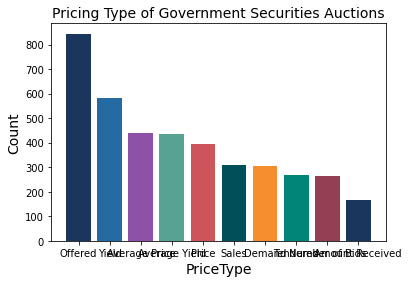

In [13]:
pyplot.rcParams["figure.figsize"] = [16, 9]

colours = [
    (27 / 255, 54 / 255, 93 / 255),
    (37 / 255, 107 / 255, 162 / 255),
    (142 / 255, 81 / 255, 168 / 255),
    (88 / 255, 162 / 255, 145 / 255),
    (205 / 255, 84 / 255, 91 / 255),
    (0 / 255, 79 / 255, 89 / 255),
    (246 / 255, 141 / 255, 46 / 255),
    (0 / 255, 133 / 255, 120 / 255),
    (147 / 255, 64 / 255, 84 / 255),
]
pyplot.bar(df_group1_top["PriceTypeD"], df_group1_top["Count"], color=colours)
pyplot.title("Pricing Type of Government Securities Auctions", fontsize=14)
pyplot.xlabel("PriceType", fontsize=14)
pyplot.ylabel("Count", fontsize=14)
pyplot.grid(False)
pyplot.autoscale()
pyplot.show()

Let's visualise the Price Type for Poland and Sweden only.

In [14]:
df_final_filtered = df_final.loc[
    (df_final["RegionD"] == "Poland") | (df_final["RegionD"] == "Sweden")
]

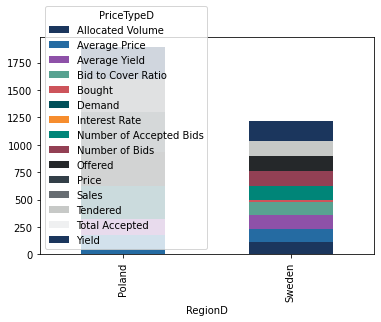

In [15]:
colours = [
    (27 / 255, 54 / 255, 93 / 255),
    (37 / 255, 107 / 255, 162 / 255),
    (142 / 255, 81 / 255, 168 / 255),
    (88 / 255, 162 / 255, 145 / 255),
    (205 / 255, 84 / 255, 91 / 255),
    (0 / 255, 79 / 255, 89 / 255),
    (246 / 255, 141 / 255, 46 / 255),
    (0 / 255, 133 / 255, 120 / 255),
    (147 / 255, 64 / 255, 84 / 255),
    (37 / 255, 40 / 255, 42 / 255),
    (51 / 255, 63 / 255, 72 / 255),
    (103 / 255, 109 / 255, 114 / 255),
    (199 / 255, 201 / 255, 199 / 255),
    (239 / 255, 240 / 255, 241 / 255),
]
df_final_filtered.groupby(["RegionD", "PriceTypeD"]).size().unstack().plot(
    kind="bar", stacked=True, color=colours
)
pyplot.show()